# Geospatial Analysis of Housing Data (Brasília - DF)

## 🏙️ Context

When we think about **buying or renting a property**, it’s common to consider factors such as **price, location, size, number of bedrooms, bathrooms, and parking spaces**. Often, when browsing real estate websites, we automatically associate the **property value** with the **area where it is located** — especially in Brasília, where neighborhoods like **Asa Sul, Asa Norte, and Jardim Botânico** have very distinct value perceptions.

But does the **price of a property depend only on its physical characteristics**, such as size and number of rooms? Or does **geographical location also play a significant role** in determining its value?

Moreover, an important question arises: could the **presence of certain nearby amenities**, such as **parks, shopping centers, schools, hospitals, or leisure areas**, contribute to **increasing the property’s value**?

In this study, we aim to investigate whether these factors truly manifest in the context of **Brasília’s real estate market**. By the end, we will seek to answer these two fundamental questions and understand **which elements most influence property values** in the capital city.

---

## 🗺️ Step 1: Load the boundaries of Brasília and the real estate dataset

To begin our analysis, we will load **the official geographic boundaries of the Federal District** and **the dataset containing real estate listings in Brasília**.

The **territorial boundaries** will be obtained directly from the **official IBGE repository**, which provides updated municipal shapefiles for all regions of Brazil. This layer will serve as a **spatial reference** to identify which properties are truly located within the administrative limits of the Federal District.
The **real estate data**, on the other hand, were collected from a **real estate listings website** and stored in a CSV file containing information such as price, number of bedrooms, bathrooms, parking spaces, and geographic coordinates (latitude and longitude).

Before moving on to exploration, it’s essential to perform a **thorough data cleaning**, since real estate datasets often contain **incorrect or inconsistent records**. Common issues include:

* Properties with **coordinates outside the Federal District boundaries**;
* Records with **missing values (`NaN`)** in key fields;
* **Unrealistic prices** — either extremely high or low compared to the market average.

To ensure our analysis is accurate, we will follow these steps:

1. **Remove records with missing values** in critical fields such as latitude, longitude, and price;
2. **Convert the dataset into a GeoDataFrame** to enable spatial operations using the coordinates;
3. **Filter only the properties located within the official polygon of the Federal District**, using the IBGE geometry as a spatial mask.

After completing this step, we will have a **clean and geographically consistent dataset**, ready for further analysis — including spatial visualization and exploration of the factors that influence real estate prices in Brasília.


📥 Loading Federal District official boundary from IBGE...
✅ Official geographic boundary successfully loaded!


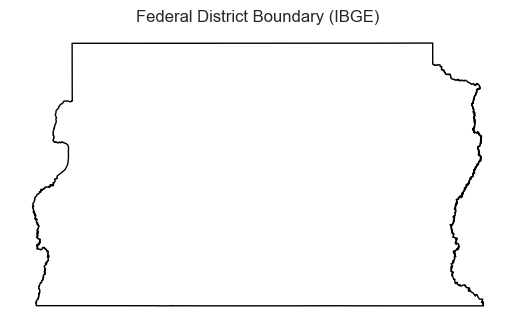

📄 Sample of the original dataset:


,aceita_pets,aquecimento_solar,ar_condicionado,area_lazer,area_servico,area_util,bairro,caracteristicas,cidade,cidade_bairro,...,salao_jogos,sauna,script_lat_long,spa,suites,url,vagas,valor,varanda,vista_livre
0,0,1,0,1,1,194.0,NOROESTE,NaN,BRASÍLIA,BRASÍLIA - NOROESTE,...,1,0,NaN,1,1.0,https://www.dfimoveis.com.br/imovel/lancamento...,1.0,NaN,1,1
1,0,1,0,1,1,600.0,LAGO SUL,NaN,BRASÍLIA,BRASÍLIA - LAGO SUL,...,0,0,NaN,1,5.0,https://www.dfimoveis.com.br/imovel/casa-4-qua...,6.0,15500000.0,1,1
2,0,0,0,0,0,126.0,ASA NORTE,NaN,BRASÍLIA,BRASÍLIA - ASA NORTE,...,0,0,NaN,0,1.0,https://www.dfimoveis.com.br/imovel/apartament...,1.0,1600000.0,0,0
3,1,0,1,0,1,590.0,LAGO SUL,NaN,BRASÍLIA,BRASÍLIA - LAGO SUL,...,0,1,NaN,0,5.0,https://www.dfimoveis.com.br/imovel/casa-4-qua...,4.0,3490000.0,1,0
4,0,1,0,1,1,77.0,NOROESTE,NaN,BRASÍLIA,BRASÍLIA - NOROESTE,...,0,1,NaN,0,2.0,https://www.dfimoveis.com.br/imovel/lancamento...,2.0,NaN,1,0


✅ 13636 records remaining after removing missing coordinates or price.
🏠 13466 properties are located inside the Federal District.
🧹 Unnecessary columns removed.
📌 Remaining columns: ['aceita_pets', 'aquecimento_solar', 'ar_condicionado', 'area_lazer', 'area_servico', 'area_util', 'bairro', 'cond_valor', 'cozinha_com_armarios', 'cozinha_espacosa', 'despensa', 'escritorio', 'gas_canalizado', 'gerador_energia', 'guarita', 'home_theater', 'interfone', 'jardim', 'lavabo', 'lazer_no_pilotis', 'mobiliado', 'pintura_nova', 'piscina', 'piso_porcelanato', 'playground', 'portao_eletronico', 'projeto_iluminacao', 'quadra_poliesportiva', 'quartos', 'sala_ginastica', 'salao_festas', 'salao_gourmet', 'salao_jogos', 'sauna', 'spa', 'suites', 'vagas', 'valor', 'varanda', 'vista_livre', 'geometry']
🧹 Removed 1 invalid neighborhood entries ('selecione').


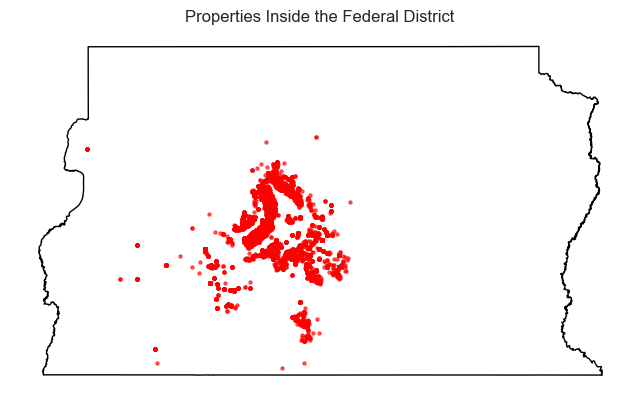

💾 File successfully exported to: REAL_STATE_DATA\properties_DF.geojson
📊 Total exported properties: 13465


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

# ======================================================
# 1️⃣ Load the Official Boundary of the Federal District (IBGE)
# ======================================================

IBGE_URL = (
    "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/"
    "malhas_municipais/municipio_2024/UFs/DF/DF_UF_2024.zip"
)

REAL_ESTATE_CSV = "REAL_STATE_DATA/brasilia.csv"
OUTPUT_DIR = "REAL_STATE_DATA"

print("📥 Loading Federal District official boundary from IBGE...")
df_poly = gpd.read_file(IBGE_URL)
print("✅ Official geographic boundary successfully loaded!")

# Visualize the boundary
df_poly.plot(edgecolor="black", facecolor="none")
plt.title("Federal District Boundary (IBGE)")
plt.axis("off")
plt.show()


# ======================================================
# 2️⃣ Load the Real Estate Dataset
# ======================================================

df = pd.read_csv(REAL_ESTATE_CSV)
print("📄 Sample of the original dataset:")
display(df.head())


# ======================================================
# 3️⃣ Initial Cleaning — Remove Missing Coordinate/Value Records
# ======================================================

df = df.dropna(subset=["latitude", "longitude", "valor"])
print(f"✅ {len(df)} records remaining after removing missing coordinates or price.")


# ======================================================
# 4️⃣ Convert to GeoDataFrame with Point Geometries
# ======================================================

gdf_properties = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)


# ======================================================
# 5️⃣ Filter Properties Inside the Federal District Boundary
# ======================================================

# Merge all polygons into a single geometry
df_union = df_poly.union_all()

mask = gdf_properties.within(df_union)
properties_df = gdf_properties[mask].copy()

print(f"🏠 {len(properties_df)} properties are located inside the Federal District.")


# ======================================================
# 6️⃣ Remove Unnecessary Columns
# ======================================================

columns_to_drop = [
    "longitude", "latitude", "cidade_bairro", "data_coleta", "descricao",
    "caracteristicas", "script_lat_long", "cidade", "imovel", "preco", "url"
]

properties_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

print("🧹 Unnecessary columns removed.")
print("📌 Remaining columns:", list(properties_df.columns))


# ======================================================
# 7️⃣ Remove Invalid Neighborhood Entries (“selecione”)
# ======================================================

if "bairro" in properties_df.columns:
    before = len(properties_df)
    properties_df = properties_df[
        properties_df["bairro"].str.lower() != "selecione"
    ].copy()
    after = len(properties_df)
    print(f"🧹 Removed {before - after} invalid neighborhood entries ('selecione').")
else:
    print("⚠️ Column 'bairro' not found in dataset.")


# ======================================================
# 8️⃣ Visualize Properties Inside the District
# ======================================================

fig, ax = plt.subplots(figsize=(8, 8))
df_poly.plot(ax=ax, color="white", edgecolor="black")
properties_df.plot(ax=ax, markersize=5, color="red", alpha=0.6)
plt.title("Properties Inside the Federal District")
plt.axis("off")
plt.show()


# ======================================================
# 9️⃣ Export the Filtered Dataset
# ======================================================

os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, "properties_DF.geojson")

properties_df.to_file(output_path, driver="GeoJSON")

print(f"💾 File successfully exported to: {output_path}")
print(f"📊 Total exported properties: {len(properties_df)}")



## 📊 Step 2: Exploratory Analysis of Geospatial Data

Now that we have a **clean and geographically consistent real estate dataset**, we can begin the **exploratory data analysis (EDA)**.
At this stage, the goal is to understand the **behavior of property values** in relation to the available variables in the dataset — **without yet considering external factors** such as proximity to parks, schools, or hospitals.

The exploratory analysis aims to answer questions such as:

* What are the **most common price ranges** among properties in Brasília?
* Is there a relationship between the **property value and the number of bedrooms, bathrooms, or parking spaces**?
* Are there **asymmetric distributions** (for example, a few very expensive properties pulling the average upward)?
* How does the **price per square meter** behave across the available records?

Before moving on to more complex models or spatial analyses, it’s important to ensure that the data is well understood and that there are no extreme outliers or inconsistencies that could distort the results.

In this stage, we will:

1. **Visualize descriptive statistics** (mean, median, standard deviation, and quartiles) of the main attributes;
2. **Graphically analyze the distribution of property values** through histograms and boxplots;
3. **Explore correlations** between price and other quantitative variables such as total area, number of bedrooms, bathrooms, and parking spaces;
4. **Calculate the price per square meter**, a useful metric for standardizing comparisons between properties of different sizes.

These analyses will help identify initial patterns, such as possible linear relationships between variables and the general behavior of the real estate market in the Federal District — serving as a foundation for later stages, where we will incorporate the **geographic component** (proximity to services and urban infrastructure).


In [2]:
import pandas as pd
import dataframe_image as dfi
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------
# 1️⃣ Configure font (supports emoji)
# ------------------------------------------------------
plt.rcParams["font.family"] = "Segoe UI Emoji"

# ------------------------------------------------------
# 2️⃣ Output directory
# ------------------------------------------------------
OUTPUT_DIR_STATS = "ANALISYS_DATA/"
os.makedirs(OUTPUT_DIR_STATS, exist_ok=True)

output_path = os.path.join(OUTPUT_DIR_STATS, "summary_statistics.png")

# ------------------------------------------------------
# 3️⃣ Compute descriptive statistics
# ------------------------------------------------------
desc = properties_df.describe().T

# ------------------------------------------------------
# 4️⃣ Style formatting
# ------------------------------------------------------
desc_styled = (
    desc.style
    .format("{:,.2f}")  # numeric formatting
    .set_caption("📊 Summary Statistics of the Property Dataset")
    .background_gradient(cmap="Blues")  # color gradient
    .set_table_styles(
        [
            {
                "selector": "caption",
                "props": [
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                    ("text-align", "left"),
                    ("color", "#2E86C1"),
                ],
            },
            {
                "selector": "th",
                "props": [
                    ("background-color", "#1B2631"),
                    ("color", "white"),
                    ("text-align", "center"),
                ],
            },
        ]
    )
)

# ------------------------------------------------------
# 5️⃣ Export styled DataFrame as PNG
# ------------------------------------------------------
dfi.export(desc_styled, output_path, table_conversion="matplotlib")

print(f"✅ Table successfully exported to: {output_path}")

# Display inside notebook (optional)
display(desc_styled)



✅ Table successfully exported to: ANALISYS_DATA/summary_statistics.png


,count,mean,std,min,25%,50%,75%,max
aceita_pets,"13,465.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
aquecimento_solar,"13,465.00",0.10,0.29,0.00,0.00,0.00,0.00,1.00
ar_condicionado,"13,465.00",0.24,0.42,0.00,0.00,0.00,0.00,1.00
area_lazer,"13,465.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
area_servico,"13,465.00",0.30,0.46,0.00,0.00,0.00,1.00,1.00
area_util,"13,465.00",725.34,"5,890.17",0.00,75.14,233.40,563.00,"470,178.00"
cond_valor,"7,218.00","1,908.28","39,095.27",0.00,457.25,671.00,"1,106.00","2,100,000.00"
cozinha_com_armarios,"13,465.00",0.26,0.44,0.00,0.00,0.00,1.00,1.00
cozinha_espacosa,"13,465.00",0.19,0.39,0.00,0.00,0.00,0.00,1.00
despensa,"13,465.00",0.14,0.35,0.00,0.00,0.00,0.00,1.00


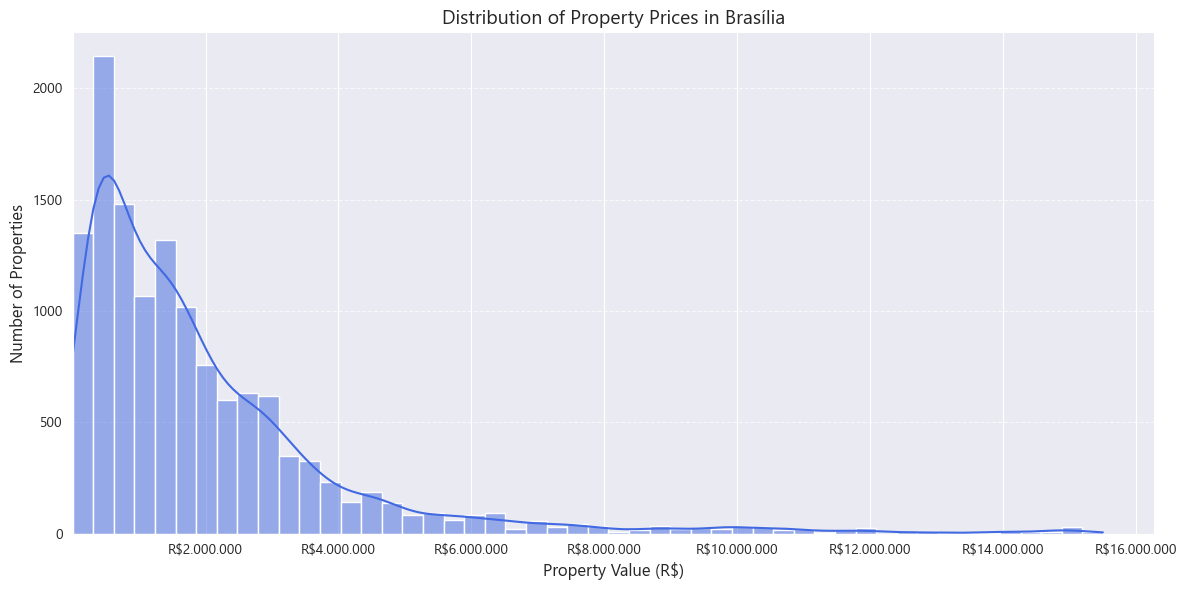

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import pandas as pd

# ------------------------------------------------------
# 1️⃣ Ensure value field is numeric
# ------------------------------------------------------
properties_df["valor"] = pd.to_numeric(properties_df["valor"], errors="coerce")

# Filter invalid or zero values (for visualization only)
filtered_df = properties_df[properties_df["valor"] > 0]

# ------------------------------------------------------
# 2️⃣ Remove extreme outliers (values above 99th percentile)
# ------------------------------------------------------
upper_limit = np.percentile(filtered_df["valor"], 99)
filtered_data = filtered_df[filtered_df["valor"] <= upper_limit]

# Determine minimum value to anchor x-axis
min_value = filtered_data["valor"].min()

# ------------------------------------------------------
# 3️⃣ Create histogram
# ------------------------------------------------------
plt.figure(figsize=(12, 6))

ax = sns.histplot(
    filtered_data["valor"],
    bins=50,
    kde=True,
    color="royalblue"
)

# ------------------------------------------------------
# 4️⃣ Title and labels
# ------------------------------------------------------
plt.title("Distribution of Property Prices in Brasília", fontsize=14, fontweight="bold")
plt.xlabel("Property Value (R$)", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)

# ------------------------------------------------------
# 5️⃣ Format x-axis values in Brazilian Real (R$)
# ------------------------------------------------------
formatter = mticker.FuncFormatter(
    lambda x, pos: f"R${x:,.0f}".replace(",", ".")
)
ax.xaxis.set_major_formatter(formatter)

# ------------------------------------------------------
# 6️⃣ Additional styling
# ------------------------------------------------------
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(left=min_value)
plt.tight_layout()

# ------------------------------------------------------
# 7️⃣ Save figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/property_value_distribution.png", dpi=300)
plt.show()


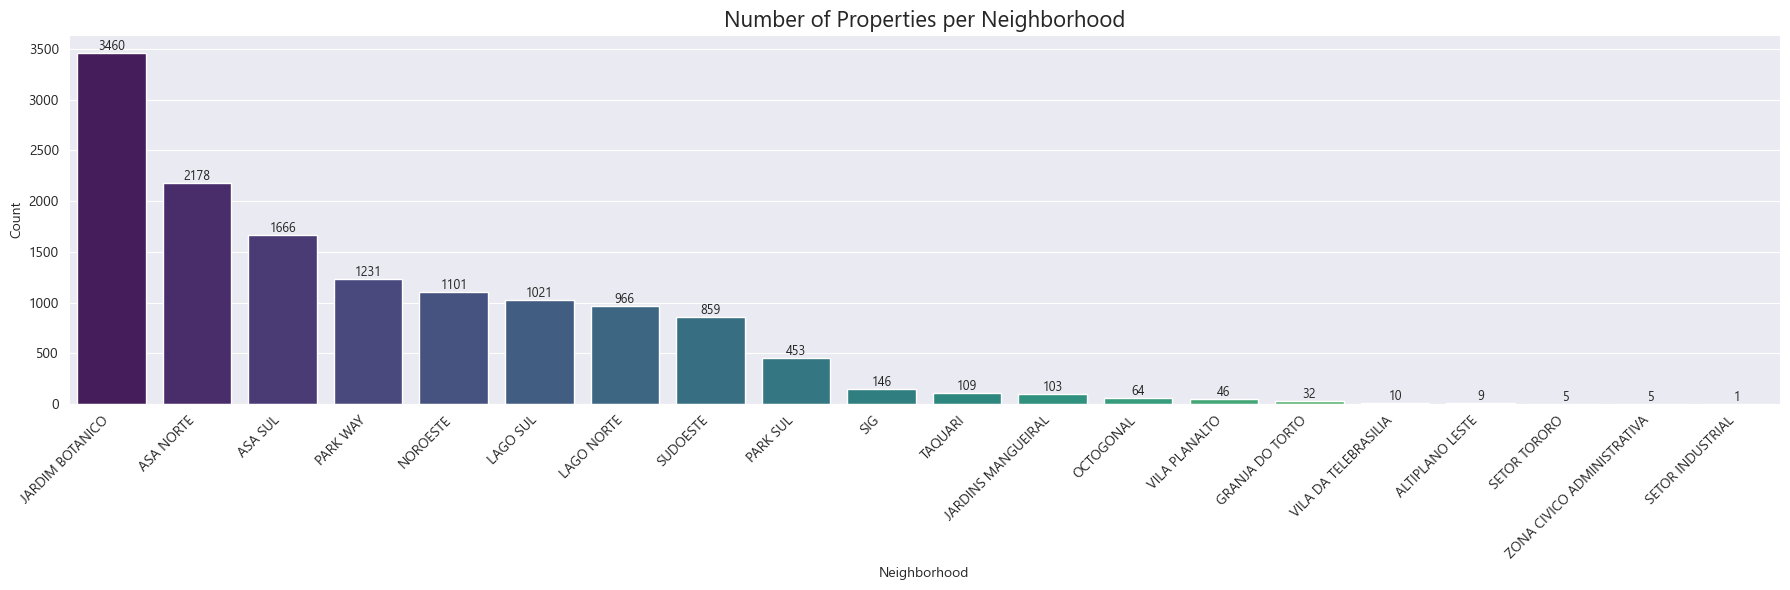

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1️⃣ Ensure the 'valor' column is numeric
# ------------------------------------------------------
properties_df["valor"] = properties_df["valor"].astype(float)

# ------------------------------------------------------
# 2️⃣ Count number of properties per neighborhood
# ------------------------------------------------------
bairro_counts = (
    properties_df["bairro"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "bairro"})
)


# Remove duplicate columns if necessary
bairro_counts = bairro_counts.loc[:, ~bairro_counts.columns.duplicated()]

# Sort neighborhoods by descending number of properties
bairro_counts = bairro_counts.sort_values(by="count", ascending=False)

# ------------------------------------------------------
# 3️⃣ Create the bar plot
# ------------------------------------------------------
plt.figure(figsize=(18, 6))

ax = sns.barplot(
    data=bairro_counts,
    x="bairro",
    y="count",
    palette="viridis",
    hue="bairro",
    dodge=False  # Prevent duplicated bars by removing hue separation
)

# ------------------------------------------------------
# 4️⃣ Add value labels above each bar
# ------------------------------------------------------
for i, v in enumerate(bairro_counts["count"]):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=9)

# ------------------------------------------------------
# 5️⃣ Formatting and style
# ------------------------------------------------------
plt.xticks(rotation=45, ha="right")
plt.title("Number of Properties per Neighborhood", fontsize=16, fontweight="bold")
plt.xlabel("Neighborhood")
plt.ylabel("Count")
plt.legend([], [], frameon=False)   # Remove legend (neighborhood names already on x-axis)
plt.tight_layout()

# ------------------------------------------------------
# 6️⃣ Save figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/neighborhood_count.png", dpi=300)
plt.show()


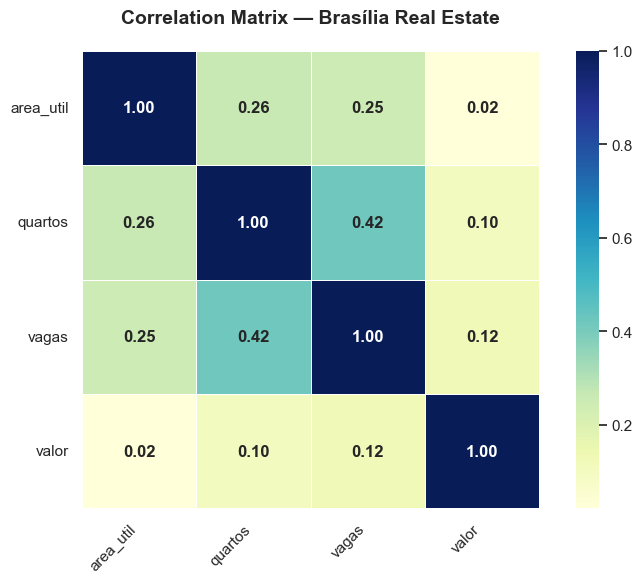

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1️⃣ Select numerical columns for correlation analysis
# ------------------------------------------------------
columns = ["area_util", "quartos", "vagas", "valor"]
corr = properties_df[columns].corr(method="pearson")

# ------------------------------------------------------
# 2️⃣ Configure figure and style
# ------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.set(style="white")

# ------------------------------------------------------
# 3️⃣ Create heatmap with annotations
# ------------------------------------------------------
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 12, "weight": "bold"},
)

# ------------------------------------------------------
# 4️⃣ Title and final adjustments
# ------------------------------------------------------
plt.title(
    "Correlation Matrix — Brasília Real Estate",
    fontsize=14,
    weight="bold",
    pad=20
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()

# ------------------------------------------------------
# 5️⃣ Save figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/corr_matrix.png", dpi=300)

plt.show()


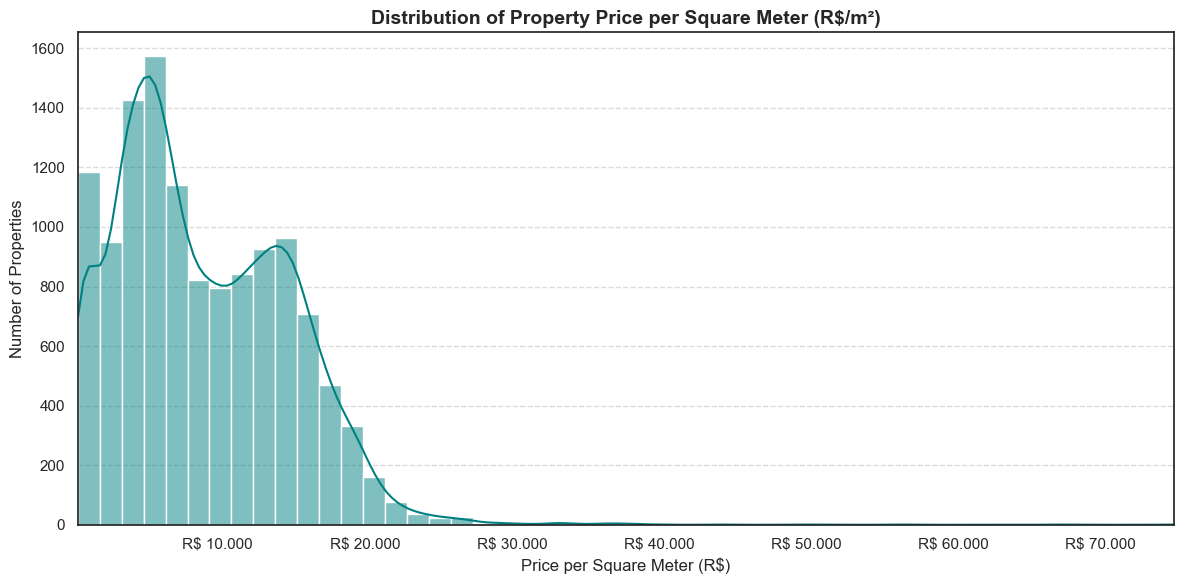

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# ------------------------------------------------------
# 1️⃣ Compute Price per Square Meter
# ------------------------------------------------------
properties_df["preco_m2"] = properties_df["valor"] / properties_df["area_util"]

# Filter out unrealistic values
properties_df = properties_df[
    (properties_df["preco_m2"] > 500) &
    (properties_df["preco_m2"] < 80000)
]

# ------------------------------------------------------
# 2️⃣ Create Histogram
# ------------------------------------------------------
plt.figure(figsize=(12, 6))

ax = sns.histplot(
    properties_df["preco_m2"],
    bins=50,
    kde=True,
    color="teal"
)

# ------------------------------------------------------
# 3️⃣ Format X-axis (Brazilian format with R$ symbol)
# ------------------------------------------------------
formatter = mticker.FuncFormatter(
    lambda x, pos: f"R$ {x:,.0f}".replace(",", ".")
)
ax.xaxis.set_major_formatter(formatter)

# ------------------------------------------------------
# 4️⃣ Labels and Layout
# ------------------------------------------------------
plt.xlim(
    left=properties_df["preco_m2"].min(),
    right=properties_df["preco_m2"].max()
)

plt.title(
    "Distribution of Property Price per Square Meter (R$/m²)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Price per Square Meter (R$)", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

# ------------------------------------------------------
# 5️⃣ Save Figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/property_price_distribution.png", dpi=300)
plt.show()


#### 💡 Interpretation of Results and Next Steps

From the analyses conducted so far, it is clear that **none of the quantitative variables alone** — such as usable area, number of bedrooms, bathrooms, or parking spaces — are strong enough to fully explain the variation in property values in Brasília. This suggests that **property prices are influenced by more than just physical characteristics**.

One important observation is the presence of **multicollinearity** among some variables — that is, variables that are highly correlated with each other. For instance, the number of bedrooms and the number of suites show a strong positive correlation, indicating that properties with more bedrooms also tend to have more suites. While this makes sense conceptually, such overlap can reduce the model’s ability to isolate the unique impact of each variable on price.

Another key finding concerns the **distribution of property prices**, which is **right-skewed (positively asymmetric)**. This means that a small number of high-priced properties pull the average upward, while most properties are concentrated in lower price ranges. This kind of asymmetry makes simple linear modeling less effective, since linear regression assumes normally distributed residuals.

---

## 📊 Step 3: Building Predictive Models for Property Values

These challenges, however, **do not prevent us from building predictive models** that can better capture the complexity of the real estate market. To address this, we will apply three distinct modeling approaches — each with a specific purpose and analytical depth:

1. **Simple Linear Regression**
   This model will attempt to predict property values based on a few key variables that are intuitively related to price. The goal is to establish a baseline understanding — even if it may not be fully accurate — of how certain features relate to value.

2. **Multiple Linear Regression (with p-value analysis)**
   In this model, we will include a broader set of variables and analyze their statistical significance through *p-values*. This will allow us to objectively identify which features truly contribute to price prediction and which do not. While we might temporarily exclude some variables with low significance, they will be kept for future verification or different analytical contexts.

3. **Random Forest Regressor**
   Finally, we will use a Random Forest model to capture **nonlinear relationships and complex interactions** between variables. This algorithm is robust against asymmetry, outliers, and multicollinearity, making it well-suited for the irregular patterns of the real estate market. It will also help identify which variables are most influential in determining property prices.

To evaluate the performance of each model, we will use standardized metrics:

* **MAE (Mean Absolute Error)**
* **RMSE (Root Mean Squared Error)**
* **R² (Coefficient of Determination)**

These metrics will allow us to **compare accuracy consistently** and determine which approach performs best in predicting property values in Brasília.
By using these benchmarks, we aim to make **data-driven, coherent, and transparent decisions** about which modeling strategy offers the best balance between interpretability and predictive power — a critical step toward understanding and forecasting property prices in the Federal District.

#### Model 1: Simple Linear Regression — Evaluating Property Values

📈 Model Evaluation Metrics:
Mean Absolute Error (MAE): R$ 1,411,894.02
Root Mean Squared Error (RMSE): R$ 3,001,925.51
R² Score: 0.2370


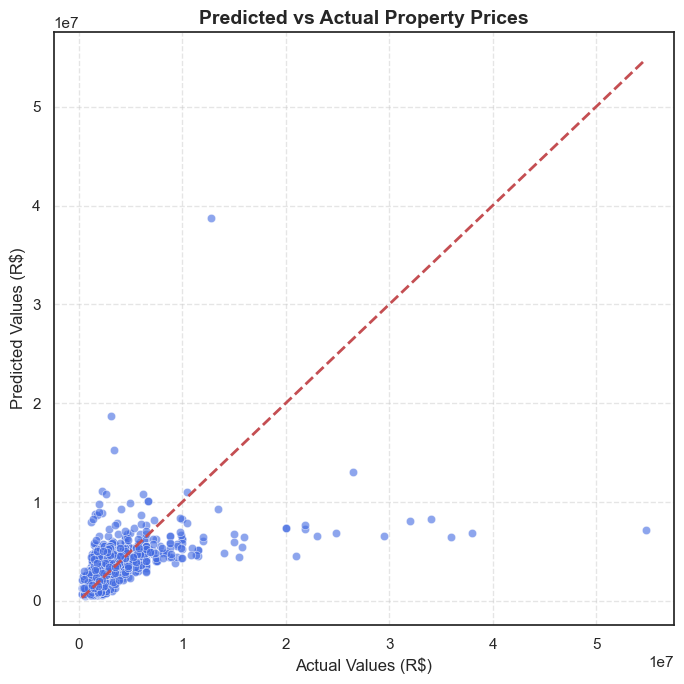


💡 Feature Importance (Linear Regression Coefficients):


,Feature,Coefficient
0,area_util,1.195386e+06
2,suites,9.049991e+05
3,vagas,3.834490e+05
4,pintura_nova,2.318520e+05
1,quartos,-1.663170e+05


In [7]:
# ======================================================
# 🧠 Linear Regression Model — Evaluating Property Prices
# ======================================================

import os
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------
# 1️⃣ Reproducibility and Output Setup
# ------------------------------------------------------
random.seed(42)

OUTPUT_DIR_MODELS = "MODEL_RESULTS/"
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

# ------------------------------------------------------
# 2️⃣ Feature Selection
# ------------------------------------------------------
# These features must exist in `properties_df`
features = ["area_util", "quartos", "suites", "vagas", "pintura_nova"]
target = "valor"

# Clean dataset (remove missing values)
data_model = properties_df[features + [target]].dropna()

# Separate variables
X = data_model[features]
y = data_model[target]

# ------------------------------------------------------
# 3️⃣ Feature Scaling
# ------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------
# 4️⃣ Train/Test Split
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------
# 5️⃣ Train Linear Regression Model
# ------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# ------------------------------------------------------
# 6️⃣ Predictions
# ------------------------------------------------------
y_pred = model.predict(X_test)

# ------------------------------------------------------
# 7️⃣ Performance Metrics
# ------------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📈 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): R$ {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): R$ {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# ------------------------------------------------------
# 8️⃣ Actual vs Predicted Plot
# ------------------------------------------------------
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="royalblue")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--", lw=2
)

plt.xlabel("Actual Values (R$)", fontsize=12)
plt.ylabel("Predicted Values (R$)", fontsize=12)
plt.title("Predicted vs Actual Property Prices", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(
    f"{OUTPUT_DIR_MODELS}/linear_regression_actual_vs_predicted.png",
    dpi=300
)
plt.show()

# ------------------------------------------------------
# 9️⃣ Display Feature Coefficients
# ------------------------------------------------------
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n💡 Feature Importance (Linear Regression Coefficients):")
display(coef_df)


#### Model 2: Multiple Linear Regression with p-value Analysis

In [8]:
# ======================================================
# 🧠 MULTIPLE LINEAR REGRESSION — WITH P-VALUE ANALYSIS
# ======================================================

import statsmodels.api as sm
import pandas as pd

# ------------------------------------------------------
# 1️⃣ Select Explanatory Variables
# ------------------------------------------------------
# Excludes categorical ('bairro') and geometric ('geometry') columns.

columns = [
    "aceita_pets", "aquecimento_solar", "ar_condicionado", "area_lazer",
    "area_servico", "area_util", "cond_valor", "cozinha_com_armarios",
    "cozinha_espacosa", "despensa", "escritorio", "gas_canalizado",
    "gerador_energia", "guarita", "home_theater", "interfone", "jardim",
    "lavabo", "lazer_no_pilotis", "mobiliado", "pintura_nova", "piscina",
    "piso_porcelanato", "playground", "portao_eletronico",
    "projeto_iluminacao", "quadra_poliesportiva", "quartos",
    "sala_ginastica", "salao_festas", "salao_gourmet", "salao_jogos",
    "sauna", "spa", "suites", "vagas", "varanda", "vista_livre",
    "preco_m2"
]

# ------------------------------------------------------
# 2️⃣ Validate Columns and Prepare Data
# ------------------------------------------------------
# Keep only columns that actually exist in the dataset
available_cols = [c for c in columns if c in properties_df.columns]

# Build dataset and drop rows with missing values
data = properties_df[available_cols + ["valor"]].dropna()

# Dependent variable (target)
y = data["valor"]

# Independent variables (predictors)
X = data[available_cols]

# Add intercept term for regression
X = sm.add_constant(X)

# ------------------------------------------------------
# 3️⃣ Fit the OLS Model
# ------------------------------------------------------
model = sm.OLS(y, X).fit()

# ------------------------------------------------------
# 4️⃣ Display Full Summary
# ------------------------------------------------------
print(model.summary())

# ------------------------------------------------------
# 5️⃣ Export Model Summary
# ------------------------------------------------------
output_file = f"{OUTPUT_DIR_MODELS}/linear_model_summary.txt"

with open(output_file, "w", encoding="utf-8") as f:
    f.write(model.summary().as_text())

print(f"📄 Model summary saved to: {output_file}")


                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     126.7
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:19:36   Log-Likelihood:                -58267.
No. Observations:                3785   AIC:                         1.166e+05
Df Residuals:                    3745   BIC:                         1.169e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.641e+06 

#### Model 3: Random Forest Regressor — Predicting Property Values


📊 Model Evaluation
MAE  (Mean Absolute Error):       R$ 83,410.94
RMSE (Root Mean Square Error):    R$ 272,633.74
R²   (Coefficient of Determination): 0.981


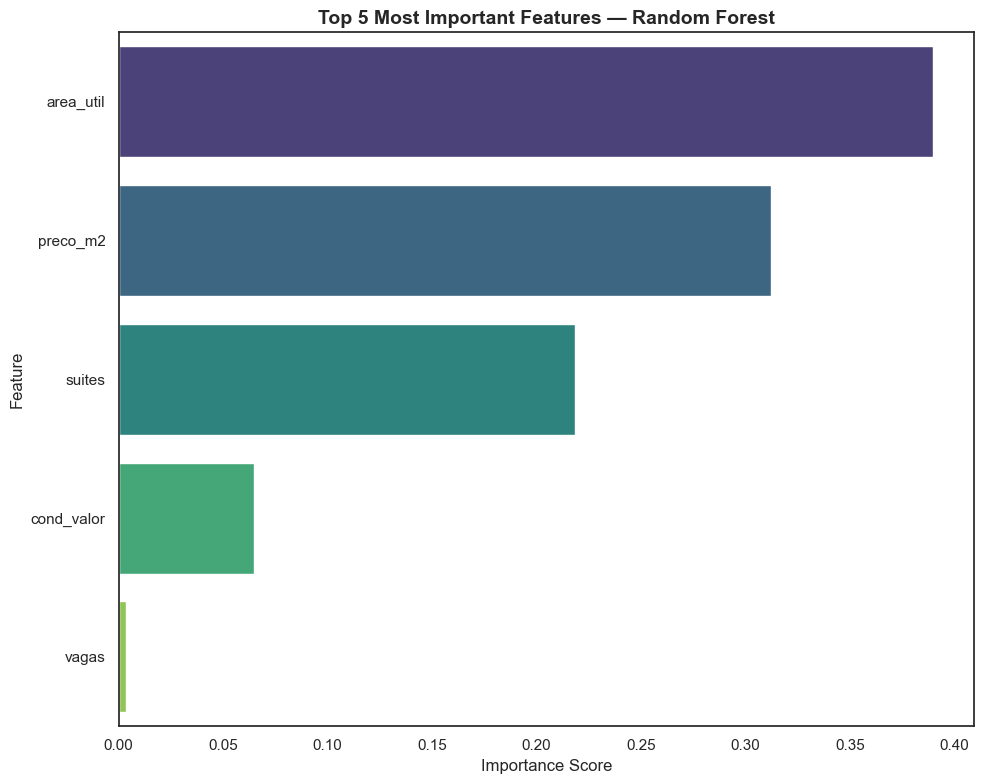


📁 Feature importance plot saved to: MODEL_RESULTS//randomforest_feature_importance.png


In [9]:
# ======================================================
# 🌲 RANDOM FOREST REGRESSOR — PROPERTY VALUE PREDICTION
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# ------------------------------------------------------
# 1️⃣ Select Predictive Features
# ------------------------------------------------------
# Excludes geometry and text columns; ensures all exist
features = [
    "aceita_pets", "aquecimento_solar", "ar_condicionado", "area_lazer",
    "area_servico", "area_util", "cond_valor", "cozinha_com_armarios",
    "cozinha_espacosa", "despensa", "escritorio", "gas_canalizado",
    "gerador_energia", "guarita", "home_theater", "interfone", "jardim",
    "lavabo", "lazer_no_pilotis", "mobiliado", "pintura_nova", "piscina",
    "piso_porcelanato", "playground", "portao_eletronico",
    "projeto_iluminacao", "quadra_poliesportiva", "quartos",
    "sala_ginastica", "salao_festas", "salao_gourmet", "salao_jogos",
    "sauna", "spa", "suites", "vagas", "varanda", "vista_livre",
    "preco_m2"
]

# Filter only features that exist in the dataset
available_features = [f for f in features if f in properties_df.columns]

# Ensure no missing values and include target variable
df_model = properties_df[available_features + ["valor"]].dropna()

X = df_model[available_features]
y = df_model["valor"]

# ------------------------------------------------------
# 2️⃣ Train/Test Split
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ------------------------------------------------------
# 3️⃣ Train Random Forest Model
# ------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

# ------------------------------------------------------
# 4️⃣ Evaluate Model Performance
# ------------------------------------------------------
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation")
print(f"MAE  (Mean Absolute Error):       R$ {mae:,.2f}")
print(f"RMSE (Root Mean Square Error):    R$ {rmse:,.2f}")
print(f"R²   (Coefficient of Determination): {r2:.3f}")

# ------------------------------------------------------
# 5️⃣ Compute Feature Importance
# ------------------------------------------------------
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# ------------------------------------------------------
# 6️⃣ Plot Top 5 Most Important Features
# ------------------------------------------------------
plt.figure(figsize=(10, 8))

sns.barplot(
    data=importances.head(5),
    x="Importance",
    y="Feature",
    palette="viridis",
    hue="Feature"
)

plt.title("Top 5 Most Important Features — Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.tight_layout()

output_fig = f"{OUTPUT_DIR_MODELS}/randomforest_feature_importance.png"
plt.savefig(output_fig, dpi=300, bbox_inches="tight")
plt.show()

print(f"\n📁 Feature importance plot saved to: {output_fig}")




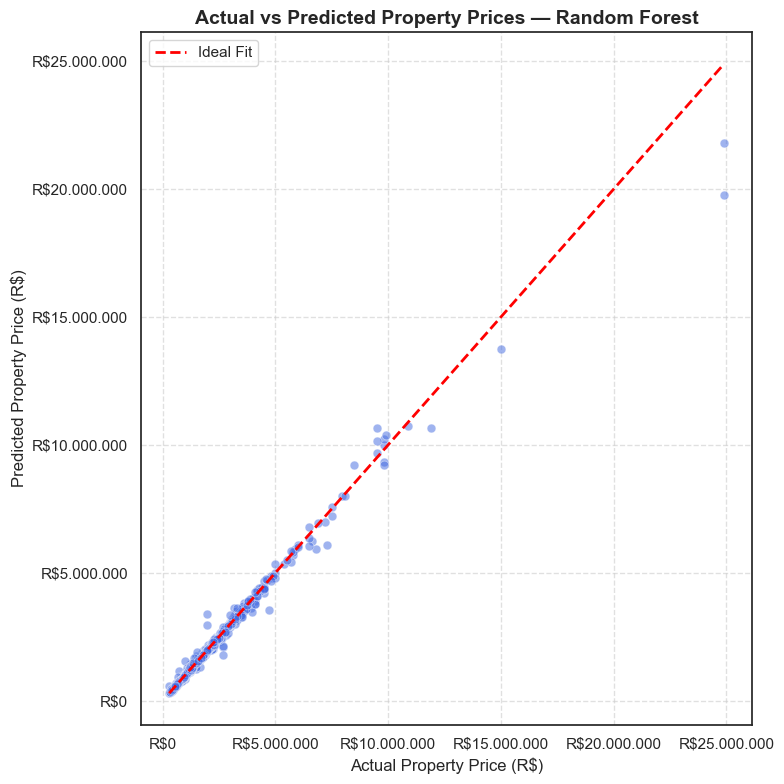

📁 Plot saved to: MODEL_RESULTS//randomforest_actual_vs_predicted.png


In [10]:
# ======================================================
# 📊 ACTUAL VS PREDICTED PLOT — RANDOM FOREST MODEL
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------
# 1. Scatter Plot — Actual vs Predicted
# ------------------------------------------------------

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_test,
    y=y_pred,
    alpha=0.5,
    color="royalblue",
    s=40
)

# ------------------------------------------------------
# 2. Ideal Reference Line (y = x)
# ------------------------------------------------------

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Fit"
)

# ------------------------------------------------------
# 3. Titles and Labels
# ------------------------------------------------------

plt.title("Actual vs Predicted Property Prices — Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Actual Property Price (R$)", fontsize=12)
plt.ylabel("Predicted Property Price (R$)", fontsize=12)

# ------------------------------------------------------
# 4. Axis Formatting (Brazilian Real)
# ------------------------------------------------------

real_formatter = FuncFormatter(lambda x, _: f"R${x:,.0f}".replace(",", "."))
plt.gca().xaxis.set_major_formatter(real_formatter)
plt.gca().yaxis.set_major_formatter(real_formatter)

# ------------------------------------------------------
# 5. Grid and Final Layout
# ------------------------------------------------------

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# ------------------------------------------------------
# 6. Save Figure
# ------------------------------------------------------

output_path = f"{OUTPUT_DIR_MODELS}/randomforest_actual_vs_predicted.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"📁 Plot saved to: {output_path}")



#### 📊 **Model Comparison — Property Value Prediction (Brasília)**

| Model                                |      MAE (R\$) |     RMSE (R\$) | R² Score  | Interpretation                                                                              |
| ------------------------------------ |---------------:|---------------:|:---------:| ------------------------------------------------------------------------------------------- |
| **Linear Regression (Simple)**       | 1,411,894.02   |   3,001,925.51 |  0.2370   | Baseline model — captures general trends but limited explanatory power.                     |
| **Multiple Linear Regression (OLS)** |              — |              — | **0.569** | Explains about 60% of price variability; significant variables identified through p-values. |
| **Random Forest Regressor**          |  **83,410.94** | **272,633.74** | **0.981** | Excellent predictive accuracy; captures nonlinear patterns and complex interactions.        |

💡 **Insights:**

* The **OLS model** improves explanatory power compared to the simple regression, highlighting important features like *usable area*, *suites*, and *vagas* (parking spaces).
* The **Random Forest model** dramatically increases predictive performance (R² ≈ 0.98), showing it can **capture complex, nonlinear relationships** that linear models miss.
* However, Random Forest sacrifices interpretability — while it predicts very well, it’s harder to explain *why* certain features matter most.

#### 📊 **Comparative Evaluation of Regression Models**

💡 **Interpretation**

* The **Random Forest model** shows **superior performance**, achieving the lowest errors and the highest R² score, indicating that it explains nearly all the variance in property values.
* The **Multiple Linear Regression** improves over the simple model but is still constrained by its linear assumptions and multicollinearity issues.
* The **Simple Linear Regression** serves as a baseline, highlighting that physical characteristics alone (like area, rooms, and parking) are insufficient to predict property prices accurately.

---

### 🏠 **Conclusion: What Really Defines Property Prices in Brasília?**

From the analyses carried out, we can conclude that **property prices in Brasília are not determined only by physical characteristics**, such as usable area, number of bedrooms, suites, or parking spaces.

The linear regression models showed that, while these features have some influence on price, **they only explain part of the variation** in property values. This suggests that other factors, beyond the internal attributes of the property, play a big role in determining prices.

The **Random Forest Regressor** model performed very well overall, showing strong predictive power and low error rates. However, it’s important to note that this model — as applied here — **did not explicitly take geographic location into account**. It used only tabular variables, without considering coordinates, neighborhoods, or spatial distances.

So, even though the Random Forest was able to capture complex relationships between features like area, number of suites, swimming pool, and finish quality, **it didn’t actually “understand” where each property is located** — which is a key element in how real estate prices are formed.

There is, however, an **indirect geographical influence**, especially through correlated variables such as **price per square meter**, which tends to reflect the difference between more and less valued areas. But this effect is only an approximation — it doesn’t replace true spatial variables.

In short, the value of a property **depends not only on what it is, but also on where it is**. Proximity to upscale neighborhoods, access to services, infrastructure quality, environmental factors, and even symbolic aspects like prestige or safety all strongly shape housing prices — yet these elements still need to be added explicitly to the model.

The next step will be to **include geographic and contextual variables** (like latitude, longitude, distance to the city center, and proximity to schools, hospitals, or parks). This will allow us to better understand **how location influences property values** and how urban space shapes the real estate market in Brasília.

---


## 🗺️ Step 4: Adding Geospatial Features to the Model

So far, we’ve reached **partial answers** to our main questions. To move forward, we need to include **geospatial variables** in our predictive model to better understand what truly drives property prices in Brasília.

The next step is to **load new datasets** containing the **locations of key points of interest**, such as hospitals, schools, parks, and shopping centers. By incorporating these spatial features, we’ll be able to analyze whether **proximity to such amenities has a measurable impact on property values**.

We expect that adding these new variables will allow us to **draw stronger and more comprehensive conclusions**, providing a clearer understanding of how **location and accessibility** shape real estate prices in the Federal District.



#### 🌍 Downloading the Required Geospatial Data

To build our geospatial database, we first need to download **OpenStreetMap (OSM) data** for the **Central-West region of Brazil**, which includes the Federal District. These data will provide detailed information on roads, buildings, green areas, and other urban features that may influence housing prices.

We will also download **specific datasets for Brasília’s metro and BRT systems**, as access to public transportation is a crucial factor that can strongly affect property values.



In [11]:
# ======================================================
# 🌍 DOWNLOAD AND EXTRACT OSM DATA — CENTRO-OESTE REGION
# ======================================================

import requests
import zipfile
import os

# ------------------------------------------------------
# 1. Output Directory
# ------------------------------------------------------

OUTPUT_DIR_GEO = "GEO_DATA"
os.makedirs(OUTPUT_DIR_GEO, exist_ok=True)

# ------------------------------------------------------
# 2. OSM Source URL (Geofabrik)
# ------------------------------------------------------

OSM_URL = (
    "https://download.geofabrik.de/south-america/brazil/"
    "centro-oeste-251111-free.shp.zip"
)

# File paths
ZIP_PATH = os.path.join(OUTPUT_DIR_GEO, "centro-oeste_OSM.zip")
EXTRACT_PATH = OUTPUT_DIR_GEO

# ------------------------------------------------------
# 3. Download OSM ZIP Package
# ------------------------------------------------------

print("⬇️ Downloading OSM data for the Centro-Oeste region...")
response = requests.get(OSM_URL, stream=True)

# Save ZIP file incrementally (safe for large files)
with open(ZIP_PATH, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

print("✅ Download completed!")

# ------------------------------------------------------
# 4. Extract ZIP Contents
# ------------------------------------------------------

print("📦 Extracting files...")
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# ------------------------------------------------------
# 5. Remove ZIP After Extraction
# ------------------------------------------------------

os.remove(ZIP_PATH)
print("🧹 ZIP file removed after extraction.")

print(f"🎉 OSM data for the Centro-Oeste region is ready in the '{OUTPUT_DIR_GEO}' folder!")


⬇️ Downloading OSM data for the Centro-Oeste region...
✅ Download completed!
📦 Extracting files...
🧹 ZIP file removed after extraction.
🎉 OSM data for the Centro-Oeste region is ready in the 'GEO_DATA' folder!


In [12]:
# ===============================================================
# 🚉 DOWNLOAD AND SAVE SUBWAY & BRT GEOSPATIAL LAYERS (BRASÍLIA)
# ===============================================================

import geopandas as gpd
import os

# ---------------------------------------------------------------
# 1. Output Directory
# ---------------------------------------------------------------

OUTPUT_DIR_GEO = "GEO_DATA"
os.makedirs(OUTPUT_DIR_GEO, exist_ok=True)

# ---------------------------------------------------------------
# 2. Source URLs — ArcGIS Hub (GeoJSON Download Endpoints)
# ---------------------------------------------------------------

URL_METRO = (
    "https://hub.arcgis.com/api/v3/datasets/92e10066030f40d49059830656ba67a9_0/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)

URL_BRT = (
    "https://hub.arcgis.com/api/v3/datasets/1dabe88927e84464bf62d928b1972ed5_2/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)

# Output file paths (Shapefiles)
METRO_PATH = os.path.join(OUTPUT_DIR_GEO, "metro_brasilia.shp")
BRT_PATH = os.path.join(OUTPUT_DIR_GEO, "brt_brasilia.shp")

# ---------------------------------------------------------------
# 3. Download Metro Layer
# ---------------------------------------------------------------

print("⬇️ Downloading Brasília Subway (Metrô) data...")
gdf_metro = gpd.read_file(URL_METRO)
print(f"✅ Subway data loaded successfully — {len(gdf_metro)} feature(s) found.")

# ---------------------------------------------------------------
# 4. Download BRT Layer
# ---------------------------------------------------------------

print("⬇️ Downloading Brasília BRT data...")
gdf_brt = gpd.read_file(URL_BRT)
print(f"✅ BRT data loaded successfully — {len(gdf_brt)} feature(s) found.")

# ---------------------------------------------------------------
# 5. Save Layers as Shapefiles
# ---------------------------------------------------------------

gdf_metro.to_file(METRO_PATH, driver="ESRI Shapefile")
gdf_brt.to_file(BRT_PATH, driver="ESRI Shapefile")

print("\n💾 Files successfully saved in the 'GEO_DATA' directory:")
print(f"   • Metrô: {METRO_PATH}")
print(f"   • BRT:   {BRT_PATH}")

print("\n🎉 Download & export process completed successfully!")




⬇️ Downloading Brasília Subway (Metrô) data...
✅ Subway data loaded successfully — 29 feature(s) found.
⬇️ Downloading Brasília BRT data...
✅ BRT data loaded successfully — 10 feature(s) found.

💾 Files successfully saved in the 'GEO_DATA' directory:
   • Metrô: GEO_DATA\metro_brasilia.shp
   • BRT:   GEO_DATA\brt_brasilia.shp

🎉 Download & export process completed successfully!


### 🗺️ Delimiting the Area of Interest — Brasília

Now that we have the **official boundary polygon of the Federal District**, we can use it to **clip (cut)** all geospatial layers — including data from **OpenStreetMap (OSM)**, the **Brasília Metro**, and the **BRT system**.

This step ensures that our analysis remains **focused exclusively on the area of interest**, removing any features located outside the boundaries of the Federal District. By doing so, we reduce noise, improve processing efficiency, and maintain spatial consistency across all datasets.

Finally, we will **save the clipped layers as new Shapefiles**, which will later be used in our **spatial analysis** and **predictive modeling** steps.

This process guarantees that every dataset — roads, transport lines, and other urban elements — aligns perfectly within the same geographic extent, forming a solid foundation for accurate and meaningful geospatial insights.


💡 **Spoiler:** The final unified geospatial dataset will be saved as a **GeoPackage file (.gpkg)** — a more efficient and modern format that ensures full compatibility with GIS software. Otherwise, we would need to export multiple shapefiles, one for each geometry type (points, lines, and polygons). After some trial and error, it became clear that exporting everything into a single GeoPackage is a much better solution.

Another important step in this process is handling the **"FID" column**, which often appears in shapefiles. This field is automatically generated by GIS software and can cause conflicts when merging multiple layers. Therefore, during the clipping and unification process, we’ll make sure to remove or rename this column to prevent any issues later on.




In [13]:
# ===============================================================
# 🗺️ MERGE, CLIP, AND EXPORT ALL GEOSPATIAL LAYERS (Brasília - DF)
# ===============================================================

import geopandas as gpd
import pandas as pd
import os
import shutil

# ===============================================================
# 1. Directories
# ===============================================================

GEO_DIR = "GEO_DATA"
OUTPUT_DIR = "GEO_DATA_FILE"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===============================================================
# 2. Load Official Boundary of Distrito Federal
# ===============================================================

print("📍 Loading official boundary of Distrito Federal...")

DF_POLY_URL = (
    "https://geoftp.ibge.gov.br/organizacao_do_territorio/"
    "malhas_territoriais/malhas_municipais/municipio_2024/UFs/DF/DF_UF_2024.zip"
)

df_boundary = gpd.read_file(DF_POLY_URL).to_crs("EPSG:4326")

print(f"✅ Boundary loaded successfully — {len(df_boundary)} feature(s) found.")


# ===============================================================
# 3. Load Geospatial Layers
# ===============================================================

layers = {
    "buildings": gpd.read_file(f"{GEO_DIR}/gis_osm_buildings_a_free_1.shp"),
    "pois": gpd.read_file(f"{GEO_DIR}/gis_osm_pois_free_1.shp"),
    "pofw_a": gpd.read_file(f"{GEO_DIR}/gis_osm_pofw_a_free_1.shp"),
    "places": gpd.read_file(f"{GEO_DIR}/gis_osm_places_free_1.shp"),
    "landuse": gpd.read_file(f"{GEO_DIR}/gis_osm_landuse_a_free_1.shp"),
    "natural": gpd.read_file(f"{GEO_DIR}/gis_osm_natural_free_1.shp"),
    "natural_a": gpd.read_file(f"{GEO_DIR}/gis_osm_natural_a_free_1.shp"),
    "transport": gpd.read_file(f"{GEO_DIR}/gis_osm_transport_free_1.shp"),
    "transport_a": gpd.read_file(f"{GEO_DIR}/gis_osm_transport_a_free_1.shp"),
    "metro": gpd.read_file(f"{GEO_DIR}/metro_brasilia.shp"),
    "brt": gpd.read_file(f"{GEO_DIR}/brt_brasilia.shp"),
}


# ===============================================================
# 4. Assign missing fclass values
# ===============================================================

layers["metro"]["fclass"] = "subway_station"
layers["brt"]["fclass"] = "brt_station"


# ===============================================================
# 5. Clip Each Layer to DF Boundary
# ===============================================================

TARGET_CRS = "EPSG:4326"
combined_layers = []

print("✂️ Clipping all layers to DF boundary...")

for name, layer in layers.items():

    # Reproject if needed
    if layer.crs != TARGET_CRS:
        layer = layer.to_crs(TARGET_CRS)

    try:
        clipped = gpd.clip(layer, df_boundary)
        clipped = clipped.loc[~clipped.geometry.is_empty]  # Remove empty geometries
        clipped["source"] = name  # Track origin layer

        # Avoid conflicts with column named "FID"
        clipped = clipped.rename(columns=lambda c: f"fid_{c}" if c.lower() == "fid" else c)

        combined_layers.append(clipped)
        print(f"✅ {name} clipped — {len(clipped)} features kept.")

    except Exception as e:
        print(f"⚠️ Skipped {name} due to error: {e}")


# ===============================================================
# 6. Merge All Layers
# ===============================================================

gdf_unified = pd.concat(combined_layers, ignore_index=True)

# Drop duplicate or conflicting columns
gdf_unified = gdf_unified.loc[:, ~gdf_unified.columns.duplicated()]

if "FID" in gdf_unified.columns or "fid" in gdf_unified.columns:
    cols_to_drop = [c for c in gdf_unified.columns if c.lower() == "fid"]
    gdf_unified = gdf_unified.drop(columns=cols_to_drop)

print(f"\n📊 Total combined features: {len(gdf_unified)}")


# ===============================================================
# 7. Export to GeoPackage
# ===============================================================

output_path = os.path.join(OUTPUT_DIR, "DF_geodata_unified.gpkg")

print("\n💾 Exporting unified GeoPackage...")
gdf_unified.to_file(output_path, driver="GPKG")

print(f"✅ GeoPackage successfully saved to: {output_path}")


# ===============================================================
# 8. Remove Original Folder
# ===============================================================

DELETE_OLD = True

if DELETE_OLD and os.path.exists(GEO_DIR):
    shutil.rmtree(GEO_DIR)
    print(f"🧹 Old directory '{GEO_DIR}' deleted.")

print("\n🎉 Process completed successfully!")


📍 Loading official boundary of Distrito Federal...
✅ Boundary loaded successfully — 1 feature(s) found.
✂️ Clipping all layers to DF boundary...
✅ buildings clipped — 36793 features kept.
✅ pois clipped — 8530 features kept.
✅ pofw_a clipped — 412 features kept.
✅ places clipped — 209 features kept.
✅ landuse clipped — 12105 features kept.
✅ natural clipped — 4662 features kept.
✅ natural_a clipped — 2 features kept.
✅ transport clipped — 1664 features kept.
✅ transport_a clipped — 143 features kept.
✅ metro clipped — 29 features kept.
✅ brt clipped — 10 features kept.

📊 Total combined features: 64559

💾 Exporting unified GeoPackage...
✅ GeoPackage successfully saved to: GEO_DATA_FILE\DF_geodata_unified.gpkg
🧹 Old directory 'GEO_DATA' deleted.

🎉 Process completed successfully!


## 🗺️ Visualizing the Geospatial Base for the Federal District

Now that we’ve built our geospatial base for the Federal District, let’s load the shapefiles saved in the previous step and visualize them with a clear legend showing the main layers available from **OpenStreetMap (OSM)** for the region.

A quick **spoiler** before we start: in the OSM dataset, you’ll notice that many layers come in pairs — some ending with “_a” and others without.

* Layers ending with **“_a”** represent **polygonal areas**, such as parks, lakes, or land-use zones.
* Layers **without “_a”** usually represent **lines or points**, like roads, buildings, or points of interest (POIs).

When visualizing the data, it’s important to understand these geometry types to correctly interpret the spatial information. To simplify our map, we’ll **merge layers with the same theme but different geometries** (for example, `natural` and `natural_a` will be combined into a single “Natural Areas” layer).

This approach will give us a **cleaner and more intuitive legend**, making the visualization clearer and more informative. As a result, we’ll have a complete geospatial map of the Federal District — it might look a bit crowded, but that’s a good sign: it means we now have **a rich spatial dataset** to work with in the next stages, where we’ll uncover valuable insights about **how urban space influences the real estate market in Brasília**.

📂 Loading unified GeoPackage...
✅ File loaded successfully — 64559 total features.


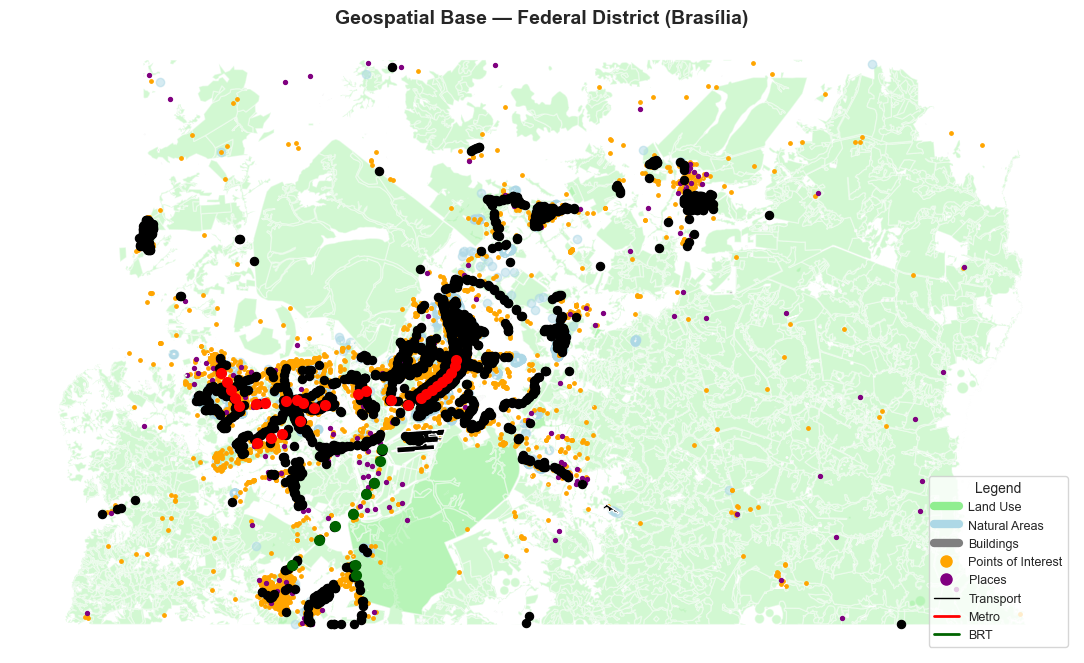

📸 Map exported successfully to: GEO_DATA_FILE/DF_geospatial_base.png


In [14]:
# ======================================================
# 🗺️ VISUALIZING THE GEOSPATIAL BASE — FEDERAL DISTRICT
# ======================================================

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ===============================================================
# 1. Path to the Unified GeoPackage
# ===============================================================

gpkg_path = f"{OUTPUT_DIR}/DF_geodata_unified.gpkg"

print("📂 Loading unified GeoPackage...")
gdf_unified = gpd.read_file(gpkg_path)
print(f"✅ File loaded successfully — {len(gdf_unified)} total features.")

# ===============================================================
# 2. Separate Layers by Source Attribute
# ===============================================================

layers = {
    "Buildings": gdf_unified[gdf_unified["source"] == "buildings"],
    "Land Use": gdf_unified[gdf_unified["source"] == "landuse"],
    "Natural Areas": gdf_unified[gdf_unified["source"].isin(["natural", "natural_a"])],
    "Points of Interest": gdf_unified[gdf_unified["source"].isin(["pois", "pofw_a"])],
    "Places": gdf_unified[gdf_unified["source"] == "places"],
    "Transport": gdf_unified[gdf_unified["source"].isin(["transport", "transport_a"])],
    "Metro": gdf_unified[gdf_unified["source"] == "metro"],
    "BRT": gdf_unified[gdf_unified["source"] == "brt"],
}

# ===============================================================
# 3. Create the Base Map
# ===============================================================

fig, ax = plt.subplots(figsize=(11, 11))

ax.set_title(
    "Geospatial Base — Federal District (Brasília)",
    fontsize=14,
    fontweight="bold"
)

# Plot in visual hierarchy order
layers["Land Use"].plot(ax=ax, color="lightgreen", alpha=0.4)
layers["Natural Areas"].plot(ax=ax, color="lightblue", alpha=0.5)
layers["Buildings"].plot(ax=ax, color="gray", alpha=0.6)
layers["Points of Interest"].plot(ax=ax, color="orange", markersize=6)
layers["Places"].plot(ax=ax, color="purple", markersize=8)
layers["Transport"].plot(ax=ax, color="black", linewidth=0.8)
layers["Metro"].plot(ax=ax, color="red", linewidth=2)
layers["BRT"].plot(ax=ax, color="darkgreen", linewidth=2)

# ===============================================================
# 4. Create Manual Legend
# ===============================================================

legend_elements = [
    Line2D([0], [0], color="lightgreen", lw=6, label="Land Use"),
    Line2D([0], [0], color="lightblue", lw=6, label="Natural Areas"),
    Line2D([0], [0], color="gray", lw=6, label="Buildings"),
    Line2D([0], [0], color="orange", marker="o", lw=0, markersize=8, label="Points of Interest"),
    Line2D([0], [0], color="purple", marker="o", lw=0, markersize=8, label="Places"),
    Line2D([0], [0], color="black", lw=1, label="Transport"),
    Line2D([0], [0], color="red", lw=2, label="Metro"),
    Line2D([0], [0], color="darkgreen", lw=2, label="BRT"),
]

ax.legend(
    handles=legend_elements,
    loc="lower right",
    fontsize=9,
    frameon=True,
    title="Legend",
    title_fontsize=10
)

# ===============================================================
# 5. Aesthetics & Output
# ===============================================================

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.4)

plt.axis("off")
plt.tight_layout()

# Save high-resolution output
output_img = f"{OUTPUT_DIR}/DF_geospatial_base.png"
plt.savefig(output_img, dpi=300, bbox_inches="tight")

plt.show()

print(f"📸 Map exported successfully to: {output_img}")


## 🧭 Definindo a Estratégia para Incorporar Variáveis Geoespaciais ao Modelo Preditivo

Chegamos a um ponto crucial do projeto: decidir **como incorporar as variáveis geoespaciais** ao nosso modelo de previsão de preços imobiliários.

Partimos da premissa de que a **localização geográfica** é um dos fatores mais determinantes no valor de um imóvel. Por isso, o próximo passo é **transformar os dados geoespaciais coletados em variáveis quantitativas** que possam ser utilizadas pelo modelo de aprendizado de máquina. No entanto, antes disso, precisamos refletir sobre **quais variáveis espaciais realmente influenciam o mercado imobiliário de Brasília**.

### 🎯 Seleção de variáveis relevantes

O conjunto de dados geoespaciais contém uma grande variedade de informações, mas **nem todas terão impacto significativo** no preço dos imóveis.
Por exemplo:

* A **proximidade de parques e áreas verdes** pode aumentar o valor de alguns imóveis, mas esse efeito pode não ser relevante em todas as regiões.
* A **distância de escolas e hospitais** tende a ser importante para famílias, mas não necessariamente para solteiros ou aposentados.
* Já a **proximidade de rodovias ou linhas de transporte público** pode ser vista como um ponto positivo para quem busca mobilidade, mas também pode ser negativa para quem se preocupa com ruído e poluição.

Esses exemplos mostram que o impacto das variáveis geoespaciais é **contextual e dependente do perfil do comprador**, o que torna a seleção das variáveis uma etapa fundamental do processo analítico.

### ⚖️ Atenção à multicolinearidade

Outro ponto importante é lidar com **colinearidade entre as variáveis**.
No modelo anterior, por exemplo, incluímos o **valor do metro quadrado** como uma variável explicativa. Entretanto, essa variável pode estar correlacionada com outros fatores espaciais, como **proximidade de áreas valorizadas** ou **acesso a infraestrutura urbana**.
Por isso, será necessário avaliar cuidadosamente a correlação entre as variáveis geoespaciais e as variáveis internas dos imóveis, de modo a **evitar problemas de multicolinearidade** que possam distorcer os resultados do modelo.

### ⚙️ Eficiência computacional

Como estamos lidando com um **grande volume de dados espaciais**, também precisamos considerar a **eficiência computacional**.
Algumas variáveis — como distâncias diretas a pontos de interesse — podem ser calculadas rapidamente, enquanto outras — como índices espaciais compostos — exigem mais processamento.
Dessa forma, será essencial **equilibrar relevância analítica e custo computacional**, garantindo que o processo de integração das variáveis seja viável e escalável.

---

## 🧮 O Problema

Temos:

* Um **DataFrame de imóveis (`properties_df`)** — cada linha representa um imóvel, com latitude/longitude ou uma geometria `Point`.
* Um **conjunto geoespacial massivo (`DF_geodata_unified.gpkg`)** — contendo diferentes tipos de feições: escolas, hospitais, parques, prédios públicos, vias, etc.

O objetivo é calcular a **distância mínima** de cada imóvel até o **ponto de interesse mais próximo** (por exemplo, o hospital mais próximo, o parque mais próximo etc.).
Isso significa criar **variáveis numéricas** como:

* `dist_hospital_min`
* `dist_escola_min`
* `dist_parque_min`

Mas o problema é o volume de cálculos:

> Se tivermos 5.000 imóveis e 10.000 pontos de interesse, são 50 milhões de combinações possíveis de distância — inviável de calcular com loops simples (`for`).

---

## ⚡ Estratégia Computacional Eficiente

A boa notícia: há **formas muito mais rápidas** de fazer isso, sem travar o computador.
Vamos decompor em etapas com foco em desempenho:

---

### 1️⃣ Converter todos os dados para o mesmo sistema de coordenadas

Usar um **CRS projetado em metros** (como `EPSG:31983` para o DF) é essencial para que as distâncias façam sentido.

```python
properties_df = properties_df.to_crs(31983)
gdf_unified = gpd.read_file("GEO_DATA_FILE/DF_geodata_unified.gpkg").to_crs(31983)
```

---

### 2️⃣ Selecionar apenas as camadas de interesse

Evite calcular distância com *todas* as feições do OSM.
Filtre apenas as que importam (escolas, hospitais, parques, etc.).

```python
pois = gdf_unified[gdf_unified['source'].isin(['pois', 'pofw_a', 'places'])]

# Exemplos de seleção textual (dependendo dos atributos disponíveis)
schools = pois[pois['fclass'].str.contains("school|college|university", case=False, na=False)]
hospitals = pois[pois['fclass'].str.contains("hospital|clinic|health", case=False, na=False)]
parks = pois[pois['fclass'].str.contains("park|garden", case=False, na=False)]
```

---

### 3️⃣ Usar *spatial indexing* (árvore R-tree)

O **GeoPandas** usa internamente a biblioteca **`pygeos`** ou **`shapely.STRtree`**, que permite criar uma **árvore espacial** e realizar consultas de vizinhança muito rapidamente.

#### Exemplo com R-tree via Shapely:

```python
from shapely.strtree import STRtree
import numpy as np

# Criar árvore espacial para hospitais
hospital_tree = STRtree(hospitals.geometry)
hospital_geoms = hospitals.geometry.values

# Calcular o hospital mais próximo para cada imóvel
nearest_distances = []
for geom in properties_df.geometry:
    nearest_geom = hospital_tree.nearest(geom)
    dist = geom.distance(nearest_geom)
    nearest_distances.append(dist)

properties_df['dist_hospital_min'] = nearest_distances
```

> 💡 Essa abordagem evita o cálculo de todas as combinações — ela busca **apenas o ponto mais próximo** para cada imóvel, reduzindo drasticamente o custo computacional (de O(n²) para ~O(n log n)).

---

### 4️⃣ Generalizar para múltiplos tipos de pontos

Podemos transformar isso em uma **função reutilizável**:

```python
def compute_nearest_distance(df_points, df_pois, label):
    tree = STRtree(df_pois.geometry)
    nearest_distances = [geom.distance(tree.nearest(geom)) for geom in df_points.geometry]
    df_points[f'dist_{label}_min'] = nearest_distances
    return df_points
```

Uso:

```python
properties_df = compute_nearest_distance(properties_df, schools, "school")
properties_df = compute_nearest_distance(properties_df, hospitals, "hospital")
properties_df = compute_nearest_distance(properties_df, parks, "park")
```

---

### 5️⃣ (Opcional) Paralelização

Se o dataset for muito grande, você pode paralelizar as operações com **Dask** ou **joblib**.

```python
from joblib import Parallel, delayed

def nearest_distance_parallel(geom, tree):
    nearest_geom = tree.nearest(geom)
    return geom.distance(nearest_geom)

tree = STRtree(hospitals.geometry)
properties_df['dist_hospital_min'] = Parallel(n_jobs=-1)(
    delayed(nearest_distance_parallel)(geom, tree) for geom in properties_df.geometry
)
```

---

## ✅ Conclusão

Essa abordagem:

* Evita loops aninhados lentos;
* Usa **índices espaciais eficientes** (R-tree);
* Calcula apenas as distâncias **mais próximas**, não todas as combinações;
* Pode ser paralelizada em múltiplos núcleos.

O resultado final será um `properties_df` enriquecido com **variáveis geoespaciais quantitativas**, prontas para alimentar o modelo de Machine Learning.

In [15]:
# ==============================================================
# 🌎 GEOSPATIAL DISTANCE CALCULATOR — CLEAN & OPTIMIZED VERSION
# ==============================================================

import geopandas as gpd
from shapely.strtree import STRtree
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import json

# ==============================================================
# 1. Paths
# ==============================================================

POI_FILE = f"{OUTPUT_DIR}/DF_geodata_unified.gpkg"
PROPERTIES_FILE = "REAL_STATE_DATA/properties_DF.geojson"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("📂 Loading POI dataset...")
pois = gpd.read_file(POI_FILE)

print("📍 Loading property dataset...")
properties_df = gpd.read_file(PROPERTIES_FILE)


# ==============================================================
# 2. Safe Geometry Cleaning
# ==============================================================

def clean_geometries(gdf):
    """
    Removes null, invalid or empty geometries.
    Repairs polygons using buffer(0) but does NOT modify points.
    """
    gdf = gdf[gdf.geometry.notnull()].copy()

    # Repair polygon geometries
    poly_mask = gdf.geom_type.isin(["Polygon", "MultiPolygon"])
    if poly_mask.any():
        gdf.loc[poly_mask, "geometry"] = gdf.loc[poly_mask, "geometry"].buffer(0)

    return gdf[gdf.is_valid & ~gdf.geometry.is_empty]


properties_df = clean_geometries(properties_df)
pois = clean_geometries(pois)


# ==============================================================
# 3. CRS Synchronization
# ==============================================================

if properties_df.crs is None:
    properties_df = properties_df.set_crs(4326)
if pois.crs is None:
    pois = pois.set_crs(4326)

# Project to SIRGAS 2000 / UTM zone 23S (metric CRS)
properties_df = properties_df.to_crs(31983)
pois = pois.to_crs(31983)

classes = sorted(pois["fclass"].dropna().unique())
print(f"📌 Found {len(classes)} unique POI categories (fclass).")


# ==============================================================
# 4. Shapely-2 Compatible Distance Function
# ==============================================================

def compute_nearest(points, targets):
    """
    Computes point-to-nearest-target distance using STRtree.
    Supports Shapely 2.x where `nearest()` returns an index.
    """
    if targets.empty:
        return [np.nan] * len(points)

    geom_list = list(targets.geometry)
    tree = STRtree(geom_list)

    distances = []

    for geom in points.geometry:
        try:
            nearest_idx = tree.nearest(geom)

            # If Shapely returns an integer index
            if isinstance(nearest_idx, (int, np.integer)):
                nearest_geom = geom_list[nearest_idx]
            else:
                nearest_geom = nearest_idx

            distances.append(geom.distance(nearest_geom))

        except Exception:
            distances.append(np.nan)

    return distances


# ==============================================================
# 5. Distance Computation Loop — No GeoDataFrame Fragmentation
# ==============================================================

print("\n🚀 Starting distance calculations...\n")

results = {}

for idx, fclass in enumerate(tqdm(classes)):
    subset = pois[pois["fclass"] == fclass]
    col_name = f"dist_{fclass}"

    print(f"📏 Computing {col_name}...")

    results[col_name] = compute_nearest(properties_df, subset)

    # Save periodic JSON checkpoints
    if idx > 0 and idx % 10 == 0:
        ckpt_path = os.path.join(OUTPUT_DIR, f"checkpoint_{idx:03d}.json")
        with open(ckpt_path, "w") as f:
            json.dump(results, f)
        print(f"💾 Checkpoint saved: {ckpt_path}")


# ==============================================================
# 6. Attach All Distance Columns at Once
# ==============================================================

print("\n🧩 Merging computed distance columns...")
distance_df = pd.DataFrame(results)
properties_df = properties_df.join(distance_df)


# ==============================================================
# 7. Save Final GeoPackage
# ==============================================================

final_path = os.path.join(OUTPUT_DIR, "properties_enriched.gpkg")
properties_df.to_file(final_path, driver="GPKG")

print("\n✅ Processing complete!")
print("📁 Final file saved as:", final_path)
print(f"📊 Total distance columns added: {len(distance_df.columns)}")


# ==============================================================
# 8. Clean Checkpoints
# ==============================================================

print("\n🧹 Removing temporary checkpoint files...")

for file in os.listdir(OUTPUT_DIR):
    if file.startswith("checkpoint_") and (file.endswith(".json") or file.endswith(".gpkg")):
        try:
            os.remove(os.path.join(OUTPUT_DIR, file))
            print(f"🗑️ Deleted: {file}")
        except Exception as e:
            print(f"⚠️ Could not delete {file}: {e}")

print("🧹 All checkpoint files removed.")


📂 Loading POI dataset...
📍 Loading property dataset...
📌 Found 167 unique POI categories (fclass).

🚀 Starting distance calculations...



  0%|          | 0/167 [00:00<?, ?it/s]

📏 Computing dist_airport...


  1%|          | 1/167 [00:00<01:01,  2.71it/s]

📏 Computing dist_allotments...


  1%|          | 2/167 [00:00<00:55,  2.96it/s]

📏 Computing dist_apron...


  2%|▏         | 3/167 [00:01<00:54,  3.02it/s]

📏 Computing dist_arts_centre...


  2%|▏         | 4/167 [00:01<00:49,  3.32it/s]

📏 Computing dist_artwork...


  3%|▎         | 5/167 [00:01<00:45,  3.57it/s]

📏 Computing dist_atm...


  4%|▎         | 6/167 [00:01<00:43,  3.72it/s]

📏 Computing dist_attraction...


  4%|▍         | 7/167 [00:01<00:41,  3.85it/s]

📏 Computing dist_bakery...


  5%|▍         | 8/167 [00:02<00:41,  3.87it/s]

📏 Computing dist_bank...


  5%|▌         | 9/167 [00:02<00:40,  3.86it/s]

📏 Computing dist_bar...


  6%|▌         | 10/167 [00:02<00:40,  3.91it/s]

📏 Computing dist_beach...


  7%|▋         | 11/167 [00:03<00:47,  3.28it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_010.json
📏 Computing dist_beauty_shop...


  7%|▋         | 12/167 [00:03<00:44,  3.46it/s]

📏 Computing dist_bench...


  8%|▊         | 13/167 [00:03<00:42,  3.62it/s]

📏 Computing dist_beverages...


  8%|▊         | 14/167 [00:03<00:40,  3.75it/s]

📏 Computing dist_bicycle_rental...


  9%|▉         | 15/167 [00:04<00:39,  3.87it/s]

📏 Computing dist_bicycle_shop...


 10%|▉         | 16/167 [00:04<00:38,  3.88it/s]

📏 Computing dist_biergarten...


 10%|█         | 17/167 [00:04<00:37,  4.02it/s]

📏 Computing dist_bookshop...


 11%|█         | 18/167 [00:04<00:37,  3.99it/s]

📏 Computing dist_brt_station...


 11%|█▏        | 19/167 [00:05<00:36,  4.04it/s]

📏 Computing dist_buddhist...


 12%|█▏        | 20/167 [00:05<00:36,  4.00it/s]

📏 Computing dist_building...


 13%|█▎        | 21/167 [00:06<00:58,  2.50it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_020.json
📏 Computing dist_bus_station...


 13%|█▎        | 22/167 [00:06<00:54,  2.68it/s]

📏 Computing dist_bus_stop...


 14%|█▍        | 23/167 [00:06<00:50,  2.88it/s]

📏 Computing dist_butcher...


 14%|█▍        | 24/167 [00:06<00:45,  3.14it/s]

📏 Computing dist_cafe...


 15%|█▍        | 25/167 [00:07<00:42,  3.32it/s]

📏 Computing dist_camera_surveillance...


 16%|█▌        | 26/167 [00:07<00:40,  3.51it/s]

📏 Computing dist_camp_site...


 16%|█▌        | 27/167 [00:07<00:37,  3.70it/s]

📏 Computing dist_car_dealership...


 17%|█▋        | 28/167 [00:07<00:36,  3.81it/s]

📏 Computing dist_car_rental...


 17%|█▋        | 29/167 [00:08<00:35,  3.89it/s]

📏 Computing dist_car_wash...


 18%|█▊        | 30/167 [00:08<00:34,  3.96it/s]

📏 Computing dist_caravan_site...


 19%|█▊        | 31/167 [00:09<00:51,  2.64it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_030.json
📏 Computing dist_cave_entrance...


 19%|█▉        | 32/167 [00:09<00:45,  2.98it/s]

📏 Computing dist_cemetery...


 20%|█▉        | 33/167 [00:09<00:43,  3.07it/s]

📏 Computing dist_chalet...


 20%|██        | 34/167 [00:09<00:39,  3.41it/s]

📏 Computing dist_chemist...


 21%|██        | 35/167 [00:10<00:37,  3.53it/s]

📏 Computing dist_christian...


 22%|██▏       | 36/167 [00:10<00:40,  3.27it/s]

📏 Computing dist_christian_catholic...


 22%|██▏       | 37/167 [00:10<00:41,  3.16it/s]

📏 Computing dist_christian_evangelical...


 23%|██▎       | 38/167 [00:11<00:41,  3.12it/s]

📏 Computing dist_christian_lutheran...


 23%|██▎       | 39/167 [00:11<00:37,  3.37it/s]

📏 Computing dist_christian_methodist...


 24%|██▍       | 40/167 [00:11<00:36,  3.43it/s]

📏 Computing dist_christian_protestant...


 25%|██▍       | 41/167 [00:12<00:58,  2.14it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_040.json
📏 Computing dist_cinema...


 25%|██▌       | 42/167 [00:12<00:49,  2.51it/s]

📏 Computing dist_city...


 26%|██▌       | 43/167 [00:13<00:43,  2.83it/s]

📏 Computing dist_clinic...


 26%|██▋       | 44/167 [00:13<00:39,  3.08it/s]

📏 Computing dist_clothes...


 27%|██▋       | 45/167 [00:13<00:37,  3.28it/s]

📏 Computing dist_college...


 28%|██▊       | 46/167 [00:13<00:34,  3.47it/s]

📏 Computing dist_commercial...


 28%|██▊       | 47/167 [00:14<00:36,  3.29it/s]

📏 Computing dist_comms_tower...


 29%|██▊       | 48/167 [00:14<00:34,  3.40it/s]

📏 Computing dist_community_centre...


 29%|██▉       | 49/167 [00:14<00:33,  3.55it/s]

📏 Computing dist_computer_shop...


 30%|██▉       | 50/167 [00:14<00:31,  3.72it/s]

📏 Computing dist_convenience...


 31%|███       | 51/167 [00:15<00:55,  2.11it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_050.json
📏 Computing dist_courthouse...


 31%|███       | 52/167 [00:16<00:46,  2.49it/s]

📏 Computing dist_dentist...


 32%|███▏      | 53/167 [00:16<00:40,  2.82it/s]

📏 Computing dist_department_store...


 32%|███▏      | 54/167 [00:16<00:35,  3.14it/s]

📏 Computing dist_doctors...


 33%|███▎      | 55/167 [00:16<00:33,  3.38it/s]

📏 Computing dist_dog_park...


 34%|███▎      | 56/167 [00:17<00:30,  3.62it/s]

📏 Computing dist_doityourself...


 34%|███▍      | 57/167 [00:17<00:29,  3.75it/s]

📏 Computing dist_drinking_water...


 35%|███▍      | 58/167 [00:17<00:28,  3.81it/s]

📏 Computing dist_embassy...


 35%|███▌      | 59/167 [00:17<00:27,  3.92it/s]

📏 Computing dist_farm...


 36%|███▌      | 60/167 [00:18<00:26,  4.03it/s]

📏 Computing dist_farmland...


 37%|███▋      | 61/167 [00:19<00:59,  1.78it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_060.json
📏 Computing dist_farmyard...


 37%|███▋      | 62/167 [00:19<00:54,  1.94it/s]

📏 Computing dist_fast_food...


 38%|███▊      | 63/167 [00:19<00:45,  2.29it/s]

📏 Computing dist_fire_station...


 38%|███▊      | 64/167 [00:20<00:39,  2.63it/s]

📏 Computing dist_florist...


 39%|███▉      | 65/167 [00:20<00:34,  2.96it/s]

📏 Computing dist_food_court...


 40%|███▉      | 66/167 [00:20<00:31,  3.25it/s]

📏 Computing dist_forest...


 40%|████      | 67/167 [00:21<00:38,  2.58it/s]

📏 Computing dist_fountain...


 41%|████      | 68/167 [00:21<00:34,  2.90it/s]

📏 Computing dist_furniture_shop...


 42%|████▏     | 70/167 [00:22<00:28,  3.38it/s]

📏 Computing dist_garden_centre...
📏 Computing dist_general...


 43%|████▎     | 71/167 [00:23<00:54,  1.75it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_070.json
📏 Computing dist_gift_shop...


 43%|████▎     | 72/167 [00:23<00:44,  2.12it/s]

📏 Computing dist_grass...


 44%|████▎     | 73/167 [00:23<00:43,  2.15it/s]

📏 Computing dist_greengrocer...


 44%|████▍     | 74/167 [00:24<00:36,  2.53it/s]

📏 Computing dist_guesthouse...


 45%|████▍     | 75/167 [00:24<00:32,  2.86it/s]

📏 Computing dist_hairdresser...


 46%|████▌     | 76/167 [00:24<00:29,  3.10it/s]

📏 Computing dist_hamlet...


 46%|████▌     | 77/167 [00:24<00:26,  3.36it/s]

📏 Computing dist_heath...


 47%|████▋     | 78/167 [00:25<00:28,  3.13it/s]

📏 Computing dist_helipad...


 47%|████▋     | 79/167 [00:25<00:28,  3.08it/s]

📏 Computing dist_hospital...


 48%|████▊     | 80/167 [00:25<00:26,  3.30it/s]

📏 Computing dist_hostel...


 49%|████▊     | 81/167 [00:27<00:52,  1.63it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_080.json
📏 Computing dist_hotel...


 49%|████▉     | 82/167 [00:27<00:43,  1.97it/s]

📏 Computing dist_hunting_stand...


 50%|████▉     | 83/167 [00:27<00:36,  2.33it/s]

📏 Computing dist_industrial...


 50%|█████     | 84/167 [00:28<00:33,  2.48it/s]

📏 Computing dist_jeweller...


 51%|█████     | 85/167 [00:28<00:29,  2.80it/s]

📏 Computing dist_jewish...


 51%|█████▏    | 86/167 [00:28<00:26,  3.06it/s]

📏 Computing dist_kindergarten...


 52%|█████▏    | 87/167 [00:28<00:24,  3.30it/s]

📏 Computing dist_kiosk...


 53%|█████▎    | 88/167 [00:29<00:22,  3.52it/s]

📏 Computing dist_laundry...


 53%|█████▎    | 89/167 [00:29<00:21,  3.66it/s]

📏 Computing dist_library...


 54%|█████▍    | 90/167 [00:29<00:20,  3.75it/s]

📏 Computing dist_locality...


 54%|█████▍    | 91/167 [00:31<00:48,  1.57it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_090.json
📏 Computing dist_mall...


 55%|█████▌    | 92/167 [00:31<00:38,  1.93it/s]

📏 Computing dist_market_place...


 56%|█████▌    | 93/167 [00:31<00:32,  2.30it/s]

📏 Computing dist_meadow...


 56%|█████▋    | 94/167 [00:31<00:31,  2.35it/s]

📏 Computing dist_memorial...


 57%|█████▋    | 95/167 [00:32<00:26,  2.72it/s]

📏 Computing dist_military...


 57%|█████▋    | 96/167 [00:33<00:37,  1.89it/s]

📏 Computing dist_mobile_phone_shop...


 58%|█████▊    | 97/167 [00:33<00:30,  2.27it/s]

📏 Computing dist_monument...


 59%|█████▊    | 98/167 [00:33<00:26,  2.61it/s]

📏 Computing dist_motel...


 59%|█████▉    | 99/167 [00:33<00:23,  2.94it/s]

📏 Computing dist_museum...


 60%|█████▉    | 100/167 [00:34<00:21,  3.18it/s]

📏 Computing dist_nature_reserve...


 60%|██████    | 101/167 [00:35<00:50,  1.32it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_100.json
📏 Computing dist_newsagent...


 61%|██████    | 102/167 [00:36<00:39,  1.65it/s]

📏 Computing dist_nightclub...


 62%|██████▏   | 103/167 [00:36<00:31,  2.01it/s]

📏 Computing dist_nursing_home...


 62%|██████▏   | 104/167 [00:36<00:26,  2.41it/s]

📏 Computing dist_observation_tower...


 63%|██████▎   | 105/167 [00:36<00:22,  2.78it/s]

📏 Computing dist_optician...


 63%|██████▎   | 106/167 [00:37<00:19,  3.06it/s]

📏 Computing dist_orchard...


 64%|██████▍   | 107/167 [00:37<00:19,  3.15it/s]

📏 Computing dist_outdoor_shop...


 65%|██████▍   | 108/167 [00:37<00:17,  3.43it/s]

📏 Computing dist_park...


 65%|██████▌   | 109/167 [00:38<00:19,  3.02it/s]

📏 Computing dist_peak...


 66%|██████▌   | 110/167 [00:38<00:17,  3.30it/s]

📏 Computing dist_pharmacy...


 66%|██████▋   | 111/167 [00:40<00:41,  1.35it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_110.json
📏 Computing dist_picnic_site...


 67%|██████▋   | 112/167 [00:40<00:32,  1.68it/s]

📏 Computing dist_pitch...


 68%|██████▊   | 113/167 [00:40<00:26,  2.06it/s]

📏 Computing dist_playground...


 68%|██████▊   | 114/167 [00:40<00:22,  2.39it/s]

📏 Computing dist_police...


 69%|██████▉   | 115/167 [00:41<00:19,  2.70it/s]

📏 Computing dist_post_box...


 69%|██████▉   | 116/167 [00:41<00:16,  3.04it/s]

📏 Computing dist_post_office...


 70%|███████   | 117/167 [00:41<00:15,  3.28it/s]

📏 Computing dist_prison...


 71%|███████   | 118/167 [00:41<00:13,  3.55it/s]

📏 Computing dist_pub...


 72%|███████▏  | 120/167 [00:42<00:12,  3.87it/s]

📏 Computing dist_public_building...
📏 Computing dist_quarry...


 72%|███████▏  | 121/167 [00:44<00:35,  1.28it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_120.json
📏 Computing dist_railway_station...


 73%|███████▎  | 122/167 [00:44<00:27,  1.61it/s]

📏 Computing dist_recreation_ground...


 74%|███████▎  | 123/167 [00:44<00:23,  1.84it/s]

📏 Computing dist_recycling...


 74%|███████▍  | 124/167 [00:45<00:19,  2.21it/s]

📏 Computing dist_recycling_glass...


 75%|███████▍  | 125/167 [00:45<00:16,  2.57it/s]

📏 Computing dist_recycling_metal...


 75%|███████▌  | 126/167 [00:45<00:13,  2.94it/s]

📏 Computing dist_recycling_paper...


 76%|███████▌  | 127/167 [00:45<00:12,  3.21it/s]

📏 Computing dist_residential...


 77%|███████▋  | 128/167 [00:46<00:13,  2.96it/s]

📏 Computing dist_restaurant...


 77%|███████▋  | 129/167 [00:46<00:12,  3.12it/s]

📏 Computing dist_retail...


 78%|███████▊  | 130/167 [00:46<00:12,  2.98it/s]

📏 Computing dist_ruins...


 78%|███████▊  | 131/167 [00:48<00:30,  1.19it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_130.json
📏 Computing dist_school...


 79%|███████▉  | 132/167 [00:49<00:23,  1.51it/s]

📏 Computing dist_scrub...


 80%|███████▉  | 133/167 [00:49<00:21,  1.61it/s]

📏 Computing dist_shelter...


 80%|████████  | 134/167 [00:49<00:16,  1.95it/s]

📏 Computing dist_shoe_shop...


 81%|████████  | 135/167 [00:50<00:13,  2.32it/s]

📏 Computing dist_sports_centre...


 81%|████████▏ | 136/167 [00:50<00:11,  2.69it/s]

📏 Computing dist_sports_shop...


 82%|████████▏ | 137/167 [00:50<00:09,  3.01it/s]

📏 Computing dist_spring...


 83%|████████▎ | 138/167 [00:50<00:08,  3.27it/s]

📏 Computing dist_stadium...


 83%|████████▎ | 139/167 [00:51<00:07,  3.50it/s]

📏 Computing dist_stationery...


 84%|████████▍ | 140/167 [00:51<00:07,  3.63it/s]

📏 Computing dist_suburb...


 84%|████████▍ | 141/167 [00:53<00:21,  1.18it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_140.json
📏 Computing dist_subway_station...


 85%|████████▌ | 142/167 [00:53<00:16,  1.50it/s]

📏 Computing dist_supermarket...


 86%|████████▌ | 143/167 [00:53<00:13,  1.83it/s]

📏 Computing dist_swimming_pool...


 86%|████████▌ | 144/167 [00:54<00:10,  2.19it/s]

📏 Computing dist_taxi...


 87%|████████▋ | 145/167 [00:54<00:08,  2.51it/s]

📏 Computing dist_telephone...


 87%|████████▋ | 146/167 [00:54<00:07,  2.83it/s]

📏 Computing dist_theatre...


 88%|████████▊ | 147/167 [00:54<00:06,  3.11it/s]

📏 Computing dist_toilet...


 89%|████████▊ | 148/167 [00:55<00:05,  3.34it/s]

📏 Computing dist_tourist_info...


 89%|████████▉ | 149/167 [00:55<00:05,  3.50it/s]

📏 Computing dist_tower...


 90%|████████▉ | 150/167 [00:55<00:04,  3.68it/s]

📏 Computing dist_town...


 90%|█████████ | 151/167 [00:58<00:14,  1.14it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_150.json
📏 Computing dist_town_hall...


 91%|█████████ | 152/167 [00:58<00:10,  1.45it/s]

📏 Computing dist_toy_shop...


 92%|█████████▏| 153/167 [00:58<00:07,  1.78it/s]

📏 Computing dist_track...


 92%|█████████▏| 154/167 [00:58<00:06,  2.14it/s]

📏 Computing dist_travel_agent...


 93%|█████████▎| 155/167 [00:59<00:04,  2.50it/s]

📏 Computing dist_tree...


 93%|█████████▎| 156/167 [00:59<00:04,  2.74it/s]

📏 Computing dist_university...


 94%|█████████▍| 157/167 [00:59<00:03,  3.04it/s]

📏 Computing dist_vending_any...


 95%|█████████▍| 158/167 [00:59<00:02,  3.34it/s]

📏 Computing dist_veterinary...


 95%|█████████▌| 159/167 [01:00<00:02,  3.51it/s]

📏 Computing dist_video_shop...


 96%|█████████▌| 160/167 [01:00<00:01,  3.62it/s]

📏 Computing dist_viewpoint...


 96%|█████████▋| 161/167 [01:02<00:05,  1.08it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_160.json
📏 Computing dist_village...


 97%|█████████▋| 162/167 [01:02<00:03,  1.39it/s]

📏 Computing dist_waste_basket...


 98%|█████████▊| 163/167 [01:03<00:02,  1.73it/s]

📏 Computing dist_wastewater_plant...


 98%|█████████▊| 164/167 [01:03<00:01,  2.11it/s]

📏 Computing dist_water_tower...


 99%|█████████▉| 165/167 [01:03<00:00,  2.46it/s]

📏 Computing dist_water_well...


 99%|█████████▉| 166/167 [01:03<00:00,  2.82it/s]

📏 Computing dist_water_works...


100%|██████████| 167/167 [01:04<00:00,  2.60it/s]



🧩 Merging computed distance columns...

✅ Processing complete!
📁 Final file saved as: GEO_DATA_FILE\properties_enriched.gpkg
📊 Total distance columns added: 167

🧹 Removing temporary checkpoint files...
🗑️ Deleted: checkpoint_010.json
🗑️ Deleted: checkpoint_020.json
🗑️ Deleted: checkpoint_030.json
🗑️ Deleted: checkpoint_040.json
🗑️ Deleted: checkpoint_050.json
🗑️ Deleted: checkpoint_060.json
🗑️ Deleted: checkpoint_070.json
🗑️ Deleted: checkpoint_080.json
🗑️ Deleted: checkpoint_090.json
🗑️ Deleted: checkpoint_100.json
🗑️ Deleted: checkpoint_110.json
🗑️ Deleted: checkpoint_120.json
🗑️ Deleted: checkpoint_130.json
🗑️ Deleted: checkpoint_140.json
🗑️ Deleted: checkpoint_150.json
🗑️ Deleted: checkpoint_160.json
🧹 All checkpoint files removed.


In [16]:
gpd.read_file("GEO_DATA_FILE/properties_enriched.gpkg")

,aceita_pets,aquecimento_solar,ar_condicionado,area_lazer,area_servico,area_util,bairro,cond_valor,cozinha_com_armarios,cozinha_espacosa,...,dist_veterinary,dist_video_shop,dist_viewpoint,dist_village,dist_waste_basket,dist_wastewater_plant,dist_water_tower,dist_water_well,dist_water_works,geometry
0,0,1,0,1,1,600.00,LAGO SUL,NaN,1,1,...,3032.930285,6581.807207,2141.051037,9001.828753,3491.917264,21646.778042,5548.865828,23358.361107,21096.536241,POINT (191023.62 8246249.151)
1,0,0,0,0,0,126.00,ASA NORTE,1000.0,0,0,...,174.824077,4844.155728,494.459820,3540.317068,1119.985681,12064.625265,2622.162271,25600.807959,21242.414088,POINT (190422.15 8257655.422)
2,1,0,1,0,1,590.00,LAGO SUL,NaN,0,0,...,5911.764508,3727.790675,2309.281468,3447.621832,4696.300439,17327.935038,5943.763199,31316.694570,28464.622357,POINT (198812.28 8249201.027)
3,1,0,0,0,1,126.00,NOROESTE,NaN,0,0,...,1580.221098,4775.445141,3045.496222,5598.723299,3093.064594,14422.294807,893.494412,23008.084282,18616.285883,POINT (187932.433 8256819.111)
4,1,0,0,0,1,170.00,ASA SUL,1370.0,0,0,...,283.264472,3902.045939,3127.961124,6622.385039,398.302447,19708.787353,4411.499929,22036.238857,19160.904914,POINT (189480.249 8249054.539)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13460,0,0,0,0,0,400.00,JARDIM BOTANICO,NaN,0,0,...,6624.631650,5427.825226,2442.526961,4131.659016,7102.291585,21497.740323,6050.678583,34750.496541,33873.704635,POINT (203897.654 8245693.455)
13461,0,0,1,0,1,107.00,JARDINS MANGUEIRAL,NaN,0,0,...,2067.486876,4123.528185,1485.457494,8793.995878,11522.803145,25152.537254,167.017059,30799.909408,29242.535818,POINT (198130.323 8241379.437)
13462,0,0,0,0,0,850.00,PARK WAY,300.0,0,0,...,3912.836060,5777.998317,12533.491167,8282.710318,6170.322696,17820.139211,3087.921030,13865.963468,13983.903553,POINT (180688.343 8241157.026)
13463,0,0,1,0,0,163.87,NOROESTE,1766.0,1,0,...,1568.803225,4430.853827,3024.866599,5771.994846,2788.565380,14560.997910,545.779956,22959.335425,18622.351721,POINT (188053.21 8256485.864)
